# Hometask 4

- Обучите CNN (самописная) на CIFAR-100.
- Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

Files already downloaded and verified


In [3]:
dataset[0][0].size

(32, 32)

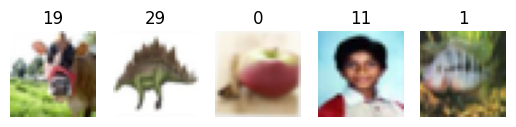

In [4]:
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(dataset[i][1])
    plt.imshow(dataset[i][0])
    plt.axis('off')

In [5]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

trans_actions = transforms.Compose([transforms.Resize(40),
                                    transforms.RandomCrop(32, padding=2), 
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor()])


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.1, random_state=42)
    return X_train, X_test

In [6]:
train_dataset, test_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
test_dataset = MyOwnCifar(test_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=10240,
                          shuffle=True,
                          num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=10240,
                          shuffle=False,
                          num_workers=1)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Загрузили данные и выяснили, что можем вычислять с помощью cuda. Значит вычисления будут не слишком долгие. Постараемся сделать сеть такую, чтобы получить результаты за не слишком долгое время.

In [43]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.bn_1 = torch.nn.BatchNorm2d(3) 
        self.conv_1 = torch.nn.Conv2d(3, 32, 3)
        self.bn_2 = torch.nn.BatchNorm2d(32) 
        self.conv_2 = torch.nn.Conv2d(32, 64, 3)
        self.bn_3 = torch.nn.BatchNorm2d(64)
        self.conv_3 = torch.nn.Conv2d(64, 128, 3)
        self.bn_4 = torch.nn.BatchNorm2d(128)
        self.dp_4 = nn.Dropout(0.33)
        self.fc4 = torch.nn.Linear(512, 256)
        self.dp_5 = nn.Dropout(0.33)   
        self.fc5 = torch.nn.Linear(256, 128)
        self.out = torch.nn.Linear(128, 100)
        
    def forward(self, x):
        x = self.bn_1(x)
        x = self.conv_1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_2(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_3(x)
        x = self.conv_3(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_4(x)
        x = x.view(x.size(0), -1)
        x = self.dp_4(x)
        x = self.fc4(x)
        x = F.relu(x)

        x = self.dp_5(x)
        x = self.fc5(x)
        x = F.relu(x)
        
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (bn_1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp_4): Dropout(p=0.33, inplace=False)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (dp_5): Dropout(p=0.33, inplace=False)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=100, bias=True)
)


In [62]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 32, 30, 30]             896
       BatchNorm2d-3           [-1, 32, 15, 15]              64
            Conv2d-4           [-1, 64, 13, 13]          18,496
       BatchNorm2d-5             [-1, 64, 6, 6]             128
            Conv2d-6            [-1, 128, 4, 4]          73,856
       BatchNorm2d-7            [-1, 128, 2, 2]             256
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 256]         131,328
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
           Linear-12                  [-1, 100]          12,900
Total params: 270,826
Trainable params: 270,826
Non-trainable params: 0
-------------------------------

Обучению подлежит 271 тыс. параметров.

In [45]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [8]:
def learn_net(net, criterion, optimizer, num_epochs):
  train_acc = []
  test_acc = []
  for epoch in range(num_epochs):
      running_loss = 0.0
      running_items = 0.0
      running_loss_test = 0.0
      running_items_test = 0.0
      running_right = 0.0
      running_right_test = 0.0

      net.train()
      for i, data in enumerate(train_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Обнуляем градиент
          optimizer.zero_grad()
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)
          # Делаем шаг назад по лоссу
          loss.backward()
          # Делаем шаг нашего оптимайзера
          optimizer.step()

          # выводим статистику о процессе обучения
          running_loss += loss.item()
          running_items += len(labels)
          running_right += (labels == torch.max(outputs, 1)[1]).sum()

      running_right = running_right.item() 
      print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
            f'Loss_train: {running_loss / (i + 1):.3f}. ' \
            f'Acc: {running_right / running_items:.3f}.', end=' ')
      acc = running_right / running_items
      train_acc.append(acc)
      # print(type(acc), acc, train_acc)
      running_loss, running_items, running_right = 0.0, 0.0, 0.0

      net.eval()
      for i, data in enumerate(test_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)

          running_loss_test += loss.item()
          running_items_test += len(labels)
          running_right_test += (labels == torch.max(outputs, 1)[1]).sum()

      running_right_test = running_right_test.item()
      print(f'Loss_test: {running_loss_test / (i + 1):.3f}. ' \
            f'Acc_test: {running_right_test / running_items_test:.3f}')
      test_acc.append(running_right_test / running_items_test)
      running_loss_test, running_items_test, running_right_test = 0.0, 0.0, 0.0

  print('Training is finished!')

  return train_acc, test_acc

In [48]:
train_acc, test_acc = learn_net(net, criterion, optimizer, 50)

Epoch [1/50]. Loss_train: 4.260. Acc: 0.049. Loss_test: 4.542. Acc_test: 0.018
Epoch [2/50]. Loss_train: 4.008. Acc: 0.079. Loss_test: 4.456. Acc_test: 0.029
Epoch [3/50]. Loss_train: 3.861. Acc: 0.101. Loss_test: 4.264. Acc_test: 0.053
Epoch [4/50]. Loss_train: 3.747. Acc: 0.117. Loss_test: 3.988. Acc_test: 0.093
Epoch [5/50]. Loss_train: 3.656. Acc: 0.135. Loss_test: 3.684. Acc_test: 0.134
Epoch [6/50]. Loss_train: 3.578. Acc: 0.145. Loss_test: 3.623. Acc_test: 0.139
Epoch [7/50]. Loss_train: 3.478. Acc: 0.163. Loss_test: 3.616. Acc_test: 0.133
Epoch [8/50]. Loss_train: 3.416. Acc: 0.175. Loss_test: 3.724. Acc_test: 0.127
Epoch [9/50]. Loss_train: 3.367. Acc: 0.183. Loss_test: 3.637. Acc_test: 0.136
Epoch [10/50]. Loss_train: 3.291. Acc: 0.199. Loss_test: 3.579. Acc_test: 0.160
Epoch [11/50]. Loss_train: 3.242. Acc: 0.202. Loss_test: 3.760. Acc_test: 0.141
Epoch [12/50]. Loss_train: 3.198. Acc: 0.214. Loss_test: 3.600. Acc_test: 0.161
Epoch [13/50]. Loss_train: 3.150. Acc: 0.224. Los

При довольно большом батче скорость обучения приемлемая, чтобы не отходить от компьютера и продолжать исследование. Главное, чтобы памяти хватало на том устройстве, где проходят вычисления.

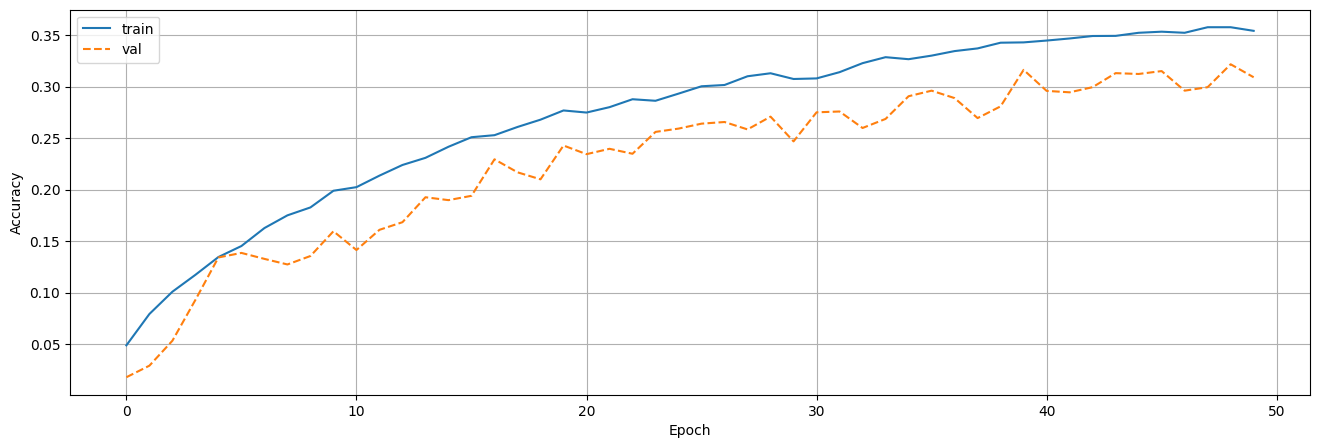

In [49]:
plt.figure(figsize = (16,5))
plt.plot(train_acc,'-',label = f'train')
plt.plot(test_acc,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Одна и вторая метрики растут, но не так быстро, как могло бы быть. Похоже, что при продолжении обучения будет скорый выход на плато и обучением остановится.

In [50]:
net.to('cpu')

Net(
  (bn_1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp_4): Dropout(p=0.33, inplace=False)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (dp_5): Dropout(p=0.33, inplace=False)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=100, bias=True)
)

In [52]:
import gc

gc.collect()
torch.cuda.empty_cache()

#### Претренированная модель

In [9]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
summary(resnet50, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

25 млн. параметров для обучения слишком много.

In [12]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

Последний слой заменим на классификатор на 100 классов.

In [13]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

Обучать будем 205 тыс. параметров. Только сеть в этот раз побольше, что явно скажется на занимаемой памяти.

In [14]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, test_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
test_dataset = MyOwnCifar(test_dataset, test_transforms)

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=512,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=512,
                                           shuffle=False)

In [16]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.005)
criterion = nn.CrossEntropyLoss()

In [17]:
train_acc, test_acc = learn_net(resnet50, criterion, optimizer, 1)

Epoch [1/1]. Loss_train: 2.837. Acc: 0.371. Loss_test: 1.697. Acc_test: 0.537
Training is finished!


Работает довольно медленно. Батч пришлось использовать 512. Перезапускать ноутбук, т.к. gс не смог освободить достаточно памяти.

Одна эпоха показала уже приличные результаты. Сделаем ещё 10.

In [18]:
train_acc1, test_acc1 = learn_net(resnet50, criterion, optimizer, 10)
train_acc.extend(train_acc1)
test_acc.extend(test_acc1)

Epoch [1/10]. Loss_train: 1.733. Acc: 0.533. Loss_test: 1.620. Acc_test: 0.555
Epoch [2/10]. Loss_train: 1.632. Acc: 0.559. Loss_test: 1.562. Acc_test: 0.571
Epoch [3/10]. Loss_train: 1.553. Acc: 0.573. Loss_test: 1.562. Acc_test: 0.566
Epoch [4/10]. Loss_train: 1.517. Acc: 0.583. Loss_test: 1.569. Acc_test: 0.572
Epoch [5/10]. Loss_train: 1.486. Acc: 0.589. Loss_test: 1.575. Acc_test: 0.573
Epoch [6/10]. Loss_train: 1.483. Acc: 0.594. Loss_test: 1.539. Acc_test: 0.588
Epoch [7/10]. Loss_train: 1.435. Acc: 0.603. Loss_test: 1.570. Acc_test: 0.575
Epoch [8/10]. Loss_train: 1.418. Acc: 0.608. Loss_test: 1.518. Acc_test: 0.589
Epoch [9/10]. Loss_train: 1.415. Acc: 0.608. Loss_test: 1.522. Acc_test: 0.596
Epoch [10/10]. Loss_train: 1.381. Acc: 0.616. Loss_test: 1.541. Acc_test: 0.590
Training is finished!


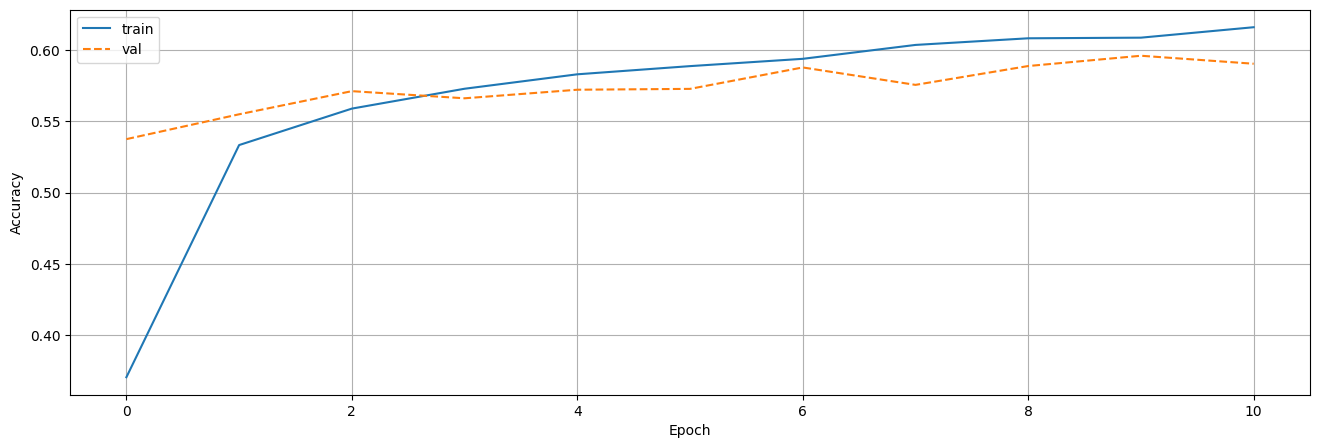

In [19]:
plt.figure(figsize = (16,5))
plt.plot(train_acc,'-',label = f'train')
plt.plot(test_acc,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [20]:
import gc

del resnet50
gc.collect()
torch.cuda.empty_cache()

Результаты не сопоставимы. Предобученная сеть показывает лучшие результаты. Плюс архитектура также сказывается.

Можно предположить, что практически с первых пяти эпох были достигнуты максимальные результаты. Далее нужны танцы с бубном, чтобы получить лучший результат. Или намного больше эпох (часов) обучения.